In [1]:
import numpy as np
import pandas as pd
import os
import time
import json
from glob import glob

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score


In [4]:
# Extract ALL available features from play-by-play
data = []
for pbp_file in pbp_files:
    game_id = os.path.basename(pbp_file).replace('pbp_', '').replace('.json', '')
    summary_file = f'./nba_data/summary_{game_id}.json'
    
    if not os.path.exists(summary_file):
        continue
    
    try:
        with open(pbp_file) as f:
            pbp = json.load(f)
        with open(summary_file) as f:
            summary = json.load(f)
        
        # Check if required keys exist
        if 'home' not in pbp or 'away' not in pbp or 'periods' not in pbp:
            print(f"Skipping {game_id}: missing required keys")
            continue
        
        home_won = summary['home']['points'] > summary['away']['points']
        home_id = pbp['home']['id']
        
    except Exception as e:
        print(f"Error loading {game_id}: {e}")
        continue
    
    for period in pbp.get('periods', []):
        # Track everything
        home_score = away_score = 0
        home_timeouts = away_timeouts = 7
        home_fouls = away_fouls = 0
        home_fgm = home_fga = away_fgm = away_fga = 0
        home_3pm = home_3pa = away_3pm = away_3pa = 0
        home_ftm = home_fta = away_ftm = away_fta = 0
        home_turnovers = away_turnovers = 0
        home_rebounds = away_rebounds = 0
        home_assists = away_assists = 0
        home_steals = away_steals = 0
        home_blocks = away_blocks = 0
        home_recent_points = away_recent_points = []
        
        last_possession_team = None
        
        for i, event in enumerate(period.get('events', [])):
            event_type = event.get('event_type', '')
            team_id = event.get('attribution', {}).get('team', {}).get('id')
            is_home = team_id == home_id
            
            # Scores
            if event_type == 'fieldgoalmade':
                points = event.get('points', 0)
                if is_home:
                    home_score += points
                    home_fgm += 1
                    home_recent_points.append(points)
                    if points == 3:
                        home_3pm += 1
                else:
                    away_score += points
                    away_fgm += 1
                    away_recent_points.append(points)
                    if points == 3:
                        away_3pm += 1
            
            elif event_type == 'fieldgoalmissed':
                if is_home:
                    home_fga += 1
                    if event.get('three_point_shot'):
                        home_3pa += 1
                else:
                    away_fga += 1
                    if event.get('three_point_shot'):
                        away_3pa += 1
            
            elif event_type == 'freethrow':
                if event.get('made'):
                    if is_home:
                        home_score += 1
                        home_ftm += 1
                        home_recent_points.append(1)
                    else:
                        away_score += 1
                        away_ftm += 1
                        away_recent_points.append(1)
                if is_home:
                    home_fta += 1
                else:
                    away_fta += 1
            
            # Other events
            elif event_type == 'timeout':
                if is_home:
                    home_timeouts = max(0, home_timeouts - 1)
                else:
                    away_timeouts = max(0, away_timeouts - 1)
            
            elif event_type == 'foul':
                if is_home:
                    home_fouls += 1
                else:
                    away_fouls += 1
            
            elif event_type == 'turnover':
                if is_home:
                    home_turnovers += 1
                else:
                    away_turnovers += 1
            
            elif event_type == 'rebound':
                if is_home:
                    home_rebounds += 1
                else:
                    away_rebounds += 1
            
            elif event_type == 'assist':
                if is_home:
                    home_assists += 1
                else:
                    away_assists += 1
            
            elif event_type == 'steal':
                if is_home:
                    home_steals += 1
                else:
                    away_steals += 1
            
            elif event_type == 'block':
                if is_home:
                    home_blocks += 1
                else:
                    away_blocks += 1
            
            home_recent_points = home_recent_points[-10:]
            away_recent_points = away_recent_points[-10:]
            
            # Sample on possession change OR every 10 events
            if team_id != last_possession_team or i % 10 == 0:
                clock = event.get('clock', '12:00')
                try:
                    mins, secs = clock.split(':')
                    time_in_period = int(mins) * 60 + int(secs)
                except:
                    time_in_period = 720
                
                # Calculate percentages safely
                home_fg_pct = home_fgm / home_fga if home_fga > 0 else 0
                away_fg_pct = away_fgm / away_fga if away_fga > 0 else 0
                home_3p_pct = home_3pm / home_3pa if home_3pa > 0 else 0
                away_3p_pct = away_3pm / away_3pa if away_3pa > 0 else 0
                home_ft_pct = home_ftm / home_fta if home_fta > 0 else 0
                away_ft_pct = away_ftm / away_fta if away_fta > 0 else 0
                
                data.append({
                    'quarter': period.get('number', 1),
                    'time_in_period': time_in_period,
                    'home_score': home_score,
                    'away_score': away_score,
                    'score_diff': home_score - away_score,
                    'home_fgm': home_fgm,
                    'home_fga': home_fga,
                    'home_fg_pct': home_fg_pct,
                    'away_fgm': away_fgm,
                    'away_fga': away_fga,
                    'away_fg_pct': away_fg_pct,
                    'home_3pm': home_3pm,
                    'home_3pa': home_3pa,
                    'home_3p_pct': home_3p_pct,
                    'away_3pm': away_3pm,
                    'away_3pa': away_3pa,
                    'away_3p_pct': away_3p_pct,
                    'home_ftm': home_ftm,
                    'home_fta': home_fta,
                    'home_ft_pct': home_ft_pct,
                    'away_ftm': away_ftm,
                    'away_fta': away_fta,
                    'away_ft_pct': away_ft_pct,
                    'home_timeouts': home_timeouts,
                    'away_timeouts': away_timeouts,
                    'home_fouls': home_fouls,
                    'away_fouls': away_fouls,
                    'home_turnovers': home_turnovers,
                    'away_turnovers': away_turnovers,
                    'home_rebounds': home_rebounds,
                    'away_rebounds': away_rebounds,
                    'home_assists': home_assists,
                    'away_assists': away_assists,
                    'home_steals': home_steals,
                    'away_steals': away_steals,
                    'home_blocks': home_blocks,
                    'away_blocks': away_blocks,
                    'home_recent_scoring': sum(home_recent_points),
                    'away_recent_scoring': sum(away_recent_points),
                    'home_won': int(home_won)
                })
                last_possession_team = team_id

# Train with ALL features
df = pd.DataFrame(data)
print(f"\nTotal snapshots: {len(df)}")
print(f"Total features: {len(df.columns) - 1}")

features = [col for col in df.columns if col != 'home_won']
X = df[features]
y = df['home_won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Log Loss: {log_loss(y_test, y_prob):.3f}")

feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 Most Important Features:")
print(feature_importance.head(10))

Skipping dee2f770-5d2e-4813-bf32-331ff558bd40: missing required keys
Skipping 6f6b9daf-1884-4dc0-950a-792db3ebdb09: missing required keys
Skipping 3afe12f1-4aec-4391-9f27-0bd061323ec8: missing required keys
Skipping 3c32d774-7e2a-42f4-aa9f-5c668b93d342: missing required keys
Skipping 11966117-1155-4163-be94-76fa2c5bf220: missing required keys
Skipping fdfd4910-98eb-40ce-83fa-ba3b37ecd32a: missing required keys
Skipping a27e8572-03d4-4609-bbd6-c1dee2c8c066: missing required keys
Skipping d8ba7f91-c175-4231-bddb-aa233f975c72: missing required keys
Skipping 9973c50e-ae5d-4429-ace6-862640697d1d: missing required keys
Skipping 653c0108-355b-4a82-a933-a35e92a9337c: missing required keys
Skipping a874dc1e-81a8-4b82-97ac-923668be301a: missing required keys
Skipping 3e073c6e-2be0-4849-8a49-fb89dfec7feb: missing required keys
Skipping 6d98d8c4-f91c-4d52-9a6e-e90092609a47: missing required keys
Skipping 11f169ec-bba4-41fa-bed8-2a8a8e763988: missing required keys
Skipping c044a416-5690-4125-965e-0

In [5]:
# Prepare data (assuming df already exists from previous code)
features = [col for col in df.columns if col != 'home_won']
X = df[features]
y = df['home_won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

# Train and evaluate all models
results = []

for name, model in models.items():
    print(f"Training {name}...")
    
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    logloss = log_loss(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Log Loss': logloss,
        'AUC-ROC': auc,
        'Train Time (s)': train_time
    })

# Create comparison table
results_df = pd.DataFrame(results).sort_values('Log Loss')

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(results_df.to_string(index=False))
print("\nBest model by Log Loss (calibration): " + results_df.iloc[0]['Model'])
print("Best model by Accuracy: " + results_df.sort_values('Accuracy', ascending=False).iloc[0]['Model'])
print("Best model by AUC-ROC: " + results_df.sort_values('AUC-ROC', ascending=False).iloc[0]['Model'])

Training Decision Tree...
Training Random Forest...
Training Gradient Boosting...
Training Logistic Regression...
Training Neural Network...

MODEL COMPARISON
              Model  Accuracy  Log Loss  AUC-ROC  Train Time (s)
Logistic Regression  0.569437  0.683879 0.510266        0.022457
      Random Forest  0.559442  0.690039 0.488180        0.459296
  Gradient Boosting  0.547080  0.693105 0.489882        0.857987
     Neural Network  0.450026  1.015751 0.503475        0.895740
      Decision Tree  0.551815  1.313396 0.497005        0.025451

Best model by Log Loss (calibration): Logistic Regression
Best model by Accuracy: Logistic Regression
Best model by AUC-ROC: Logistic Regression


In [11]:
# Get the best model from comparison
best_model_name = results_df.iloc[0]['Model']
print(f"Using best model: {best_model_name}")

# Set best_model based on what won
if 'Neural' in best_model_name:
    # Use the tuned Neural Network
    best_model = MLPClassifier(
        hidden_layer_sizes=(300, 150), activation='relu',
        alpha=0.0005, learning_rate='adaptive', max_iter=2000, random_state=42
    )
    best_model.fit(X_train_scaled, y_train)
    use_scaled = True
else:
    # Use the tuned Random Forest
    best_model = RandomForestClassifier(
        n_estimators=300, max_depth=10, max_features='sqrt',
        min_samples_leaf=2, min_samples_split=5, random_state=42
    )
    best_model.fit(X_train, y_train)
    use_scaled = False

print(f"Model trained and ready for predictions!\n")


Using best model: Logistic Regression
Model trained and ready for predictions!



In [26]:
game_index = 1

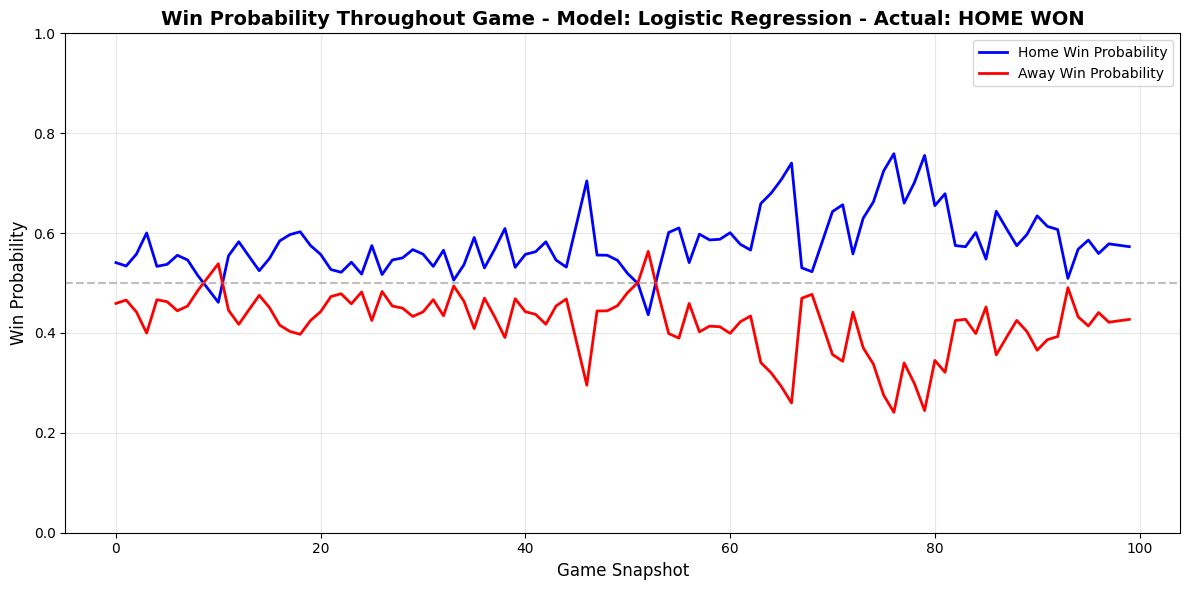

Final prediction: 57.3% home win
Actual outcome: HOME WON


In [27]:

# Now plot with best model
import matplotlib.pyplot as plt

# Pick one game from the data
sample_game_id = df['game_id'].unique()[game_index] if 'game_id' in df.columns else None

if sample_game_id is None:
    game_snapshots = df.iloc[:100].copy()
else:
    game_snapshots = df[df['game_id'] == sample_game_id].copy()

# Get predictions for each snapshot (use scaled data if NN)
if use_scaled:
    game_features_scaled = scaler.transform(game_snapshots[features])
    game_snapshots['home_win_prob'] = best_model.predict_proba(game_features_scaled)[:, 1]
else:
    game_snapshots['home_win_prob'] = best_model.predict_proba(game_snapshots[features])[:, 1]

game_snapshots['away_win_prob'] = 1 - game_snapshots['home_win_prob']

# Create plot
plt.figure(figsize=(12, 6))

plt.plot(game_snapshots.index, game_snapshots['home_win_prob'], 
         label='Home Win Probability', linewidth=2, color='blue')
plt.plot(game_snapshots.index, game_snapshots['away_win_prob'], 
         label='Away Win Probability', linewidth=2, color='red')

plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('Game Snapshot', fontsize=12)
plt.ylabel('Win Probability', fontsize=12)
plt.ylim(0, 1)
plt.legend()
plt.grid(alpha=0.3)

actual_outcome = "HOME WON" if game_snapshots['home_won'].iloc[-1] == 1 else "AWAY WON"
plt.title(f'Win Probability Throughout Game - Model: {best_model_name} - Actual: {actual_outcome}', 
          fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Final prediction: {game_snapshots['home_win_prob'].iloc[-1]:.1%} home win")
print(f"Actual outcome: {actual_outcome}")

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

# -------------------------------
# 1️⃣ Get the best model from comparison
# -------------------------------
best_model_name = results_df.iloc[0]['Model']
print(f"Using best model: {best_model_name}")

if 'Neural' in best_model_name:
    # Tuned Neural Network
    best_model = MLPClassifier(
        hidden_layer_sizes=(300, 150),
        activation='relu',
        alpha=0.0005,
        learning_rate='adaptive',
        max_iter=2000,
        random_state=42
    )
    best_model.fit(X_train_scaled, y_train)
    use_scaled = True
else:
    # Tuned Random Forest
    best_model = RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        max_features='sqrt',
        min_samples_leaf=2,
        min_samples_split=5,
        random_state=42
    )
    best_model.fit(X_train, y_train)
    use_scaled = False

print("Model trained and ready for predictions!\n")

# -------------------------------
# 2️⃣ Create summary table for all games
# -------------------------------
game_summary = []

for idx, row in df.iterrows():
    home_team = row['home_team'] if 'home_team' in df.columns else 'Home'
    away_team = row['away_team'] if 'away_team' in df.columns else 'Away'
    
    # Prepare features as DataFrame to avoid sklearn warnings
    X_new = pd.DataFrame([row[features]], columns=features)
    
    # Predict probability
    if use_scaled:
        X_new_scaled = scaler.transform(X_new)
        final_prob = best_model.predict_proba(X_new_scaled)[0, 1]
    else:
        final_prob = best_model.predict_proba(X_new)[0, 1]
    
    actual_won = row['home_won']
    
    game_summary.append({
        'Game': f"{away_team} @ {home_team}",
        'Predicted Home Win %': f"{final_prob:.1%}",
        'Actual Result': 'HOME WON' if actual_won == 1 else 'AWAY WON',
        'Correct?': '1' if (final_prob >= 0.5) == actual_won else '0'
    })

summary_df = pd.DataFrame(game_summary)

print("\n" + "="*100)
print("ALL GAMES SUMMARY")
print("="*100)
print(summary_df.to_string(index=False))

# Overall accuracy
correct = summary_df['Correct?'].value_counts().get('1', 0)
total = len(summary_df)
print("\n" + "="*100)
print(f"Overall Prediction Accuracy: {correct}/{total} ({correct/total:.1%})")
print("="*100)

Using best model: Logistic Regression
Model trained and ready for predictions!


ALL GAMES SUMMARY
       Game Predicted Home Win % Actual Result Correct?
Away @ Home                54.1%      AWAY WON        0
Away @ Home                53.4%      AWAY WON        0
Away @ Home                55.8%      AWAY WON        0
Away @ Home                60.0%      AWAY WON        0
Away @ Home                53.3%      AWAY WON        0
Away @ Home                53.7%      AWAY WON        0
Away @ Home                55.6%      AWAY WON        0
Away @ Home                54.6%      AWAY WON        0
Away @ Home                51.5%      AWAY WON        0
Away @ Home                48.8%      AWAY WON        1
Away @ Home                46.1%      AWAY WON        1
Away @ Home                55.5%      AWAY WON        0
Away @ Home                58.3%      AWAY WON        0
Away @ Home                55.3%      AWAY WON        0
Away @ Home                52.5%      AWAY WON        0
Away 